{/* cspell:ignore bppeps */}


# Simulate 2D tilted-field Ising with QESEM Qiskit Function

*Usage estimate: 20 minutes on a Heron r2 processor. (NOTE: This is an estimate only. Your runtime may vary.)*

## Background

This tutorial shows how to simulate the dynamics of a canonical quantum spin model, the 2D tilted-field Ising (TFI) model with non clifford angles using [QESEM Qedma's qiskit function](https://quantum.cloud.ibm.com/docs/en/guides/qedma-qesem):

$$
H = J \sum_{\langle i,j \rangle} Z_i Z_j + g_x \sum_i X_i + g_z \sum_i Z_i ,
$$

where $ \langle i,j \rangle $ denotes nearest neighbors on a lattice. Simulating the time evolution of many-body quantum systems is a computationally hard task for classical computers. Quantum computers, by contrast, are naturally designed to perform this task efficiently. The TFI model, in particular, has become a popular benchmark on quantum hardware due to its rich physical behavior and hardware friendly implementation.

Instead of simulating continuous-time dynamics, we adopt the closely related kicked Ising model. The dynamics can be expressed exactly as a periodic quantum circuit, where each evolution step consists of three layers of fractional two-qubit gates $ R_{ZZ} (\alpha_{ZZ}) $, interleaved with layers of single-qubit gates $ R_X (\alpha_X) $ and $ R_Z (\alpha_Z) $.

We will use generic angles that are challenging for both classical simulation and error mitigation. Specifically, we chose $ \alpha_{ZZ} = 1.0 $, $ \alpha_X = 0.53 $, and $ \alpha_Z = 0.1 $, placing the model far from any integrable point.

In this tutorial we will:
* Estimate the expected QPU runtime for full error mitigation using QESEM's analytical and empirical time estimation features.
* Construct and simulate the 2D tilted-field Ising model circuit using hardware-inspired qubit layouts and gate layers.
* Visualize device qubit connectivity and selected subgraphs for your experiment.
* Demonstrate the use of [operator backpropagation (OBP)](https://quantum.cloud.ibm.com/docs/en/guides/qiskit-addons-obp) to reduce circuit depth. This technique trims operations from the circuit end at the cost of more operator measurements.
* Perform unbiased error mitigation (EM) for multiple observables simultaneously using the QESEM qiskit function, comparing ideal, noisy, and mitigated results.
* Analyze and plot the impact of error mitigation on magnetization across different circuit depths.

Note: OBP will generally return a set of possibly non-commuting observables. QESEM automatically optimizes measurement bases when target observables contain non-commuting terms. It generates candidate measurement basis sets using several heuristic algorithms and selects the set that minimizes the number of distinct bases. This means QESEM groups compatible observables into common bases to reduce the total number of measurement configurations required, improving efficiency.

## About QESEM

QESEM is a reliable, high accuracy, characterization-based software implementing efficient, unbiased quasi-probabilistic error mitigation.
It is designed to mitigate errors in generic quantum circuits and it is application agnostic. It has been validated across diverse hardware platforms, including utility-scale experiments on IBM Eagle and Heron devices. The QESEM workflow stages are as follows:

1. Device characterization - maps gate fidelities and identifies coherent errors, providing real-time calibration data. this stage ensures that mitigation leverages the highest-fidelity available operations.
2. Noise-aware transpilation - generates and evaluates alternative qubit mappings, operation sets, and measurement bases, selecting the variant that minimizes estimated QPU runtime, with optional parallelization to accelerate data collection.
3. Error suppression - redefines native gates, applies Pauli twirling, and optimizes pulse-level control (on
supported platforms) to improve fidelity.
4. Circuit characterization - builds a tailored local error model and fits it to QPU measurements to quantify residual noise.
5. Error mitigation - constructs multi-type quasi-probabilistic decompositions and samples from them in an adaptive process that minimizes mitigation QPU time and sensitivity to hardware fluctuations, achieving high accuracies at large circuit volumes.

For more information on QESEM and a utility-scale experiment of this model on a 103-qubit, high-connectivity subgraph of the native heavy-hex geometry of ibm_marrakesh, you can refer to [Reliable high-accuracy error mitigation for utility-scale quantum circuits](https://arxiv.org/abs/2508.10997).

![QESEM workflow.](/docs/images/tutorials/qedma-2d-ising-with-qesem/QESEM_workflow.avif)

## Requirements

Install the following Python packages before running the notebook:

- Qiskit SDK v2.0.0 or later (`pip install qiskit`)
- Qiskit Runtime v0.40.0 or later (`pip install qiskit-ibm-runtime`)
- Qiskit Functions Catalog v0.8.0 or later ( `pip install qiskit-ibm-catalog` )
- Qiskit Operator Back Propagation add on v0.3.0 or later ( `pip install qiskit-addon-obp` )
- Qiskit Utils add on v0.1.1 or later ( `pip install qiskit-addon-utils` )
- Qiskit Aer simulator v0.17.1 or later ( `pip install qiskit-aer` )
- Matplotlib v3.10.3 or later ( `pip install matplotlib` )

## Setup
Let's import the relevant libraries:

In [10]:
%matplotlib inline

from typing import Sequence

import matplotlib.pyplot as plt
import numpy as np
import json

import qiskit
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_catalog import QiskitFunctionsCatalog
from qiskit_aer import AerSimulator
from qiskit_addon_utils.slicing import combine_slices, slice_by_gate_types
from qiskit_addon_obp import backpropagate
from qiskit_addon_obp.utils.simplify import OperatorBudget
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.visualization import (
    plot_gate_map,
)

Let's set your [IBM Quantum Platform](https://quantum.cloud.ibm.com/) credentials and load the QESEM function:

In [ ]:
# Paste here your instance and token strings

instance = "YOUR_INSTANCE"
token = "YOUR_TOKEN"
channel = "ibm_quantum_platform"

catalog = QiskitFunctionsCatalog(
    channel=channel, token=token, instance=instance
)
qesem_function = catalog.load("qedma/qesem")

## Step 1: Map classical inputs to a quantum problem

We'll start by defining a function that creates the trotter circuit:

In [12]:
def trotter_circuit_from_layers(
    steps: int,
    theta_x: float,
    theta_z: float,
    theta_zz: float,
    layers: Sequence[Sequence[tuple[int, int]]],
    init_state: str | None = None,
) -> qiskit.QuantumCircuit:
    """
    Generates an ising trotter circuit
    :param steps: trotter steps
    :param theta_x: RX angle
    :param theta_z: RZ angle
    :param theta_zz: RZZ angle
    :param layers: list of layers (can be list of layers in device)
    :param init_state: Initial state to prepare. If None, will not prepare any state. If "+", will
     add Hadamard gates to all qubits.
    :return: QuantumCircuit
    """
    qubits = sorted({i for layer in layers for edge in layer for i in edge})
    circ = qiskit.QuantumCircuit(max(qubits) + 1)

    if init_state == "+":
        print("init_state = +")
        for q in qubits:
            circ.h(q)

    for _ in range(steps):
        for q in qubits:
            circ.rx(theta_x, q)
            circ.rz(theta_z, q)

        for layer in layers:
            for edge in layer:
                circ.rzz(theta_zz, *edge)
        circ.barrier(qubits)

    return circ

And a function to calculate ideal expectation values using the Aer simulator.
Note that for large circuits (30+ qubits) we recommend using precalculated values from belief-propagation (BP) PEPS simulations. This code includes precalculated values for 35 qubits as an example, based on the BP approach for evolving a PEPS tensor network introduced [here](https://www.science.org/doi/10.1126/sciadv.adk4321) (which we refer to as PEPS-BP), using the tensor-network Python package [quimb](https://joss.theoj.org/papers/10.21105/joss.00819).

In [123]:
def calculate_ideal_evs(circ, obs, num_qubits, step):
    # Predefined results for large circuits - calculated using bppeps for 3, 5, 7, 9 trotter steps
    predefined_35 = [
        0.79537,
        0.78653,
        0.79699,
    ]

    if num_qubits == 35:
        print(
        "Using precalculated ideal values for large circuits calculated with belief propagation PEPS. Currently only for 35 qubits.")
        return predefined_35[step]

    else:
        simulator = AerSimulator()

        # Use Estimator primitive to get expectation value
        estimator = Estimator(simulator)
        sim_result = estimator.run([(circ, [obs])], precision=0.0001).result()

        # Extracting the result
        ideal_values = sim_result[0].data.evs[0]
        return ideal_values

We use a hardware-based $R_{ZZ}$ layer mapping taken from the Heron device, from which we cut out the layers according to the number of qubits we want to simulate. We define subgraphs for 10, 21, 28, 35 qubits that maintain a 2D structure, feel free to change to your favorite subgraph:

In [14]:
LAYERS_HERON_R2 = [  # the full set of hardware layers for heron r2
    [
        (2, 3),
        (6, 7),
        (10, 11),
        (14, 15),
        (20, 21),
        (16, 23),
        (24, 25),
        (17, 27),
        (28, 29),
        (18, 31),
        (32, 33),
        (19, 35),
        (36, 41),
        (42, 43),
        (37, 45),
        (46, 47),
        (38, 49),
        (50, 51),
        (39, 53),
        (60, 61),
        (56, 63),
        (64, 65),
        (57, 67),
        (68, 69),
        (58, 71),
        (72, 73),
        (59, 75),
        (76, 81),
        (82, 83),
        (77, 85),
        (86, 87),
        (78, 89),
        (90, 91),
        (79, 93),
        (94, 95),
        (100, 101),
        (96, 103),
        (104, 105),
        (97, 107),
        (108, 109),
        (98, 111),
        (112, 113),
        (99, 115),
        (116, 121),
        (122, 123),
        (117, 125),
        (126, 127),
        (118, 129),
        (130, 131),
        (119, 133),
        (134, 135),
        (140, 141),
        (136, 143),
        (144, 145),
        (137, 147),
        (148, 149),
        (138, 151),
        (152, 153),
        (139, 155),
    ],
    [
        (1, 2),
        (3, 4),
        (5, 6),
        (7, 8),
        (9, 10),
        (11, 12),
        (13, 14),
        (21, 22),
        (23, 24),
        (25, 26),
        (27, 28),
        (29, 30),
        (31, 32),
        (33, 34),
        (40, 41),
        (43, 44),
        (45, 46),
        (47, 48),
        (49, 50),
        (51, 52),
        (53, 54),
        (55, 59),
        (61, 62),
        (63, 64),
        (65, 66),
        (67, 68),
        (69, 70),
        (71, 72),
        (73, 74),
        (80, 81),
        (83, 84),
        (85, 86),
        (87, 88),
        (89, 90),
        (91, 92),
        (93, 94),
        (95, 99),
        (101, 102),
        (103, 104),
        (105, 106),
        (107, 108),
        (109, 110),
        (111, 112),
        (113, 114),
        (120, 121),
        (123, 124),
        (125, 126),
        (127, 128),
        (129, 130),
        (131, 132),
        (133, 134),
        (135, 139),
        (141, 142),
        (143, 144),
        (145, 146),
        (147, 148),
        (149, 150),
        (151, 152),
        (153, 154),
    ],
    [
        (3, 16),
        (7, 17),
        (11, 18),
        (22, 23),
        (26, 27),
        (30, 31),
        (34, 35),
        (21, 36),
        (25, 37),
        (29, 38),
        (33, 39),
        (41, 42),
        (44, 45),
        (48, 49),
        (52, 53),
        (43, 56),
        (47, 57),
        (51, 58),
        (62, 63),
        (66, 67),
        (70, 71),
        (74, 75),
        (61, 76),
        (65, 77),
        (69, 78),
        (73, 79),
        (81, 82),
        (84, 85),
        (88, 89),
        (92, 93),
        (83, 96),
        (87, 97),
        (91, 98),
        (102, 103),
        (106, 107),
        (110, 111),
        (114, 115),
        (101, 116),
        (105, 117),
        (109, 118),
        (113, 119),
        (121, 122),
        (124, 125),
        (128, 129),
        (132, 133),
        (123, 136),
        (127, 137),
        (131, 138),
        (142, 143),
        (146, 147),
        (150, 151),
        (154, 155),
        (0, 1),
        (4, 5),
        (8, 9),
        (12, 13),
        (54, 55),
        (15, 19),
    ],
]

subgraphs = {  # the subgraphs for the different qubit counts such that it's 2D
    10: list(range(22, 29)) + [16, 17, 37],
    21: list(range(3, 12)) + list(range(23, 32)) + [16, 17, 18],
    28: list(range(3, 12))
    + list(range(23, 32))
    + list(range(45, 50))
    + [16, 17, 18, 37, 38],
    35: list(range(3, 12))
    + list(range(21, 32))
    + list(range(41, 50))
    + [16, 17, 18, 36, 37, 38],
    42: list(range(3, 12))
    + list(range(21, 32))
    + list(range(41, 50))
    + list(range(63, 68))
    + [16, 17, 18, 36, 37, 38, 56, 57],
}

n_qubits = 35  # 21, 28, 35, 42

In [15]:
layers = [
    [
        edge
        for edge in layer
        if edge[0] in subgraphs[n_qubits] and edge[1] in subgraphs[n_qubits]
    ]
    for layer in LAYERS_HERON_R2
]

print(layers)

[[(6, 7), (10, 11), (16, 23), (24, 25), (17, 27), (28, 29), (18, 31), (36, 41), (42, 43), (37, 45), (46, 47), (38, 49)], [(3, 4), (5, 6), (7, 8), (9, 10), (21, 22), (23, 24), (25, 26), (27, 28), (29, 30), (43, 44), (45, 46), (47, 48)], [(3, 16), (7, 17), (11, 18), (22, 23), (26, 27), (30, 31), (21, 36), (25, 37), (29, 38), (41, 42), (44, 45), (48, 49), (4, 5), (8, 9)]]


Let's visualize the qubit layout on the Heron device for the selected subgraph:

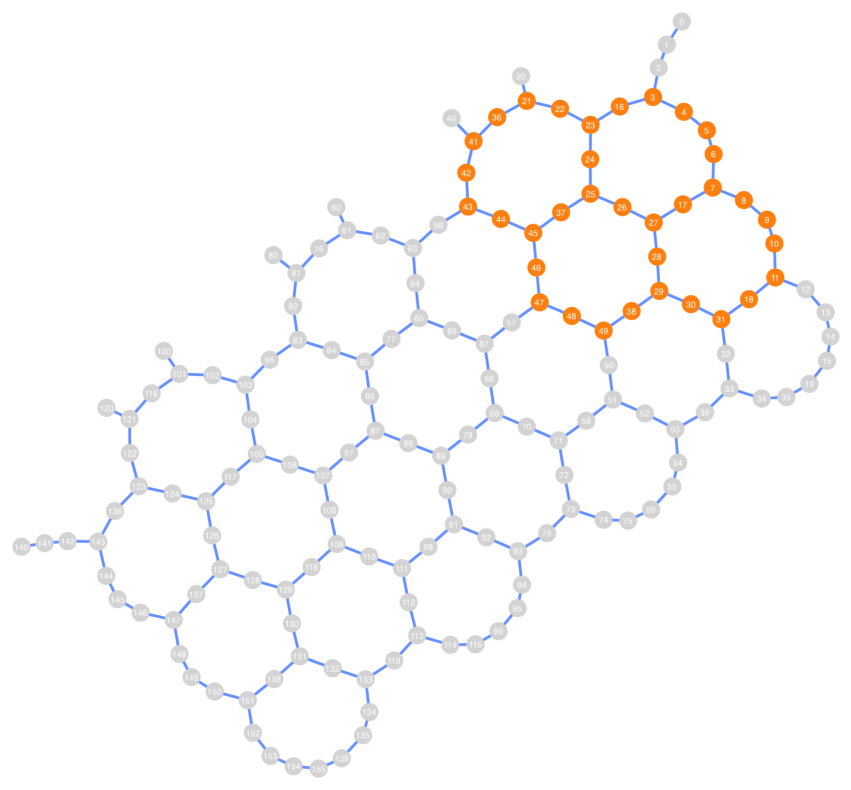

In [16]:
service = QiskitRuntimeService(
    channel=channel,
    token=token,
    instance=instance,
)
backend = service.backend("ibm_fez")  # or any available device

selected_qubits = subgraphs[n_qubits]
num_qubits = backend.configuration().num_qubits
qubit_color = [
    "#ff7f0e" if i in selected_qubits else "#d3d3d3"
    for i in range(num_qubits)
]

plot_gate_map(
    backend=backend,
    figsize=(15, 10),
    qubit_color=qubit_color,
)
plt.show()

Notice that the connectivity of the chosen qubit layout is not necessarily linear, and can cover large regions of the Heron device depending on the selected number of qubits.

Now let's generate the trotter circuit and the average magnetization observable for the chosen number of qubits and parameters:

Circuit 2q layers: 27

Circuit structure:


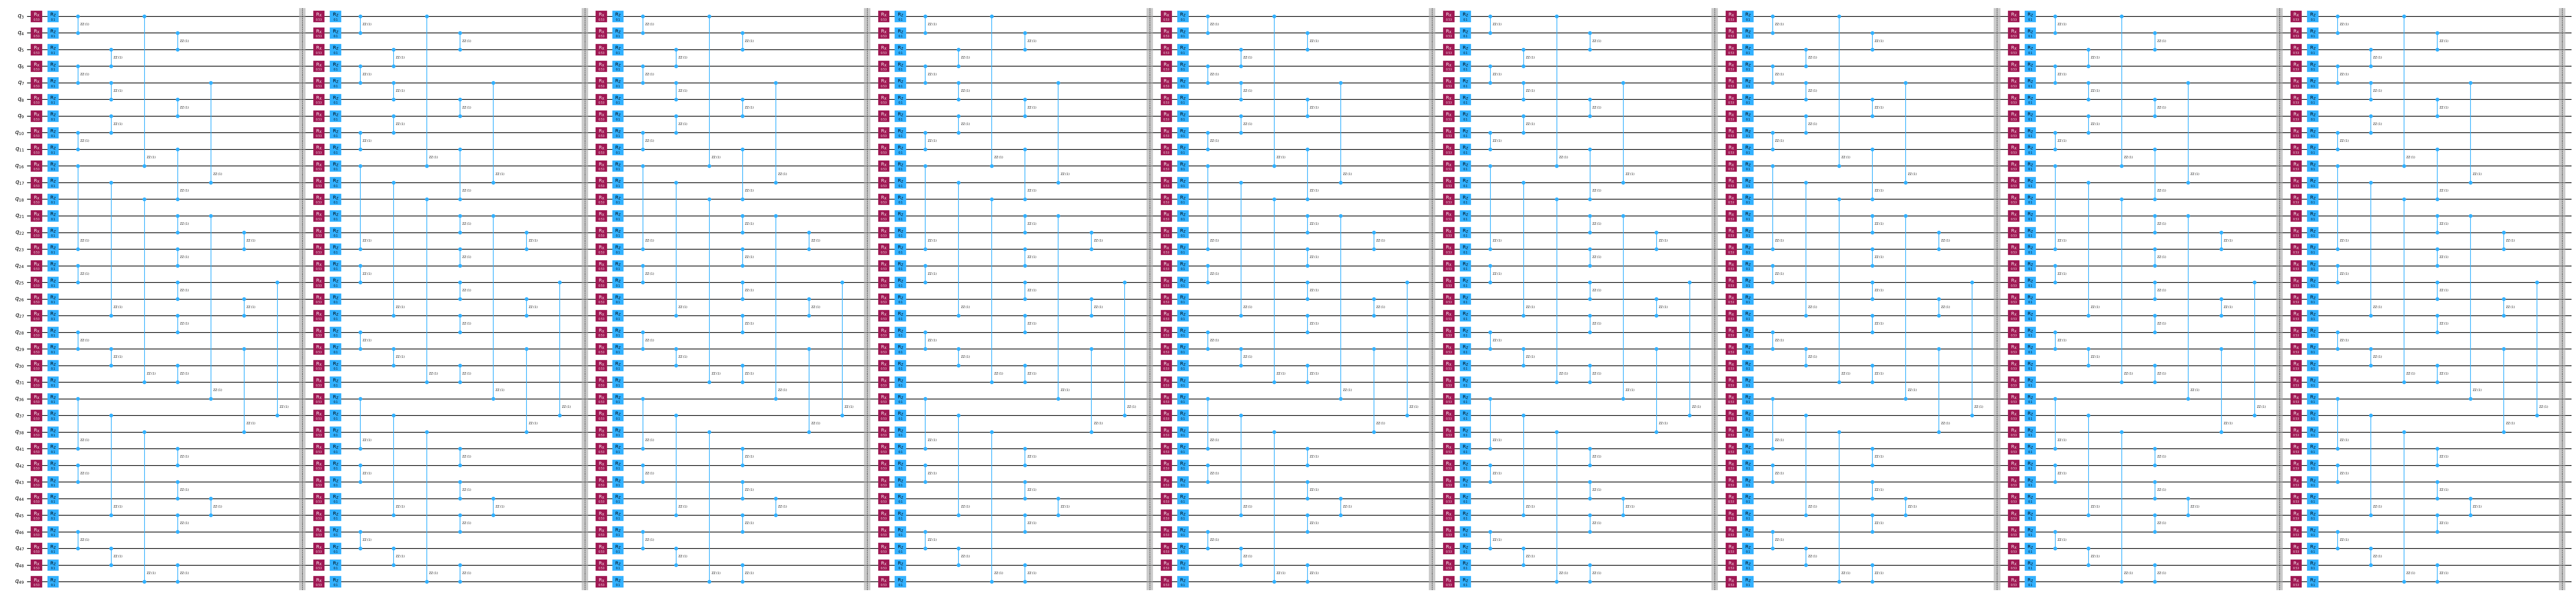

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIII

In [20]:
# Chosen parameters:
theta_x = 0.53
theta_z = 0.1
theta_zz = 1.0
steps = 9

circ = trotter_circuit_from_layers(steps, theta_x, theta_z, theta_zz, layers)
print(
    f"Circuit 2q layers: {circ.depth(filter_function=lambda instr: len(instr.qubits) == 2)}"
)
print("\nCircuit structure:")

circ.draw("mpl", scale=0.8, fold=-1, idle_wires=False)
plt.show()

observable = qiskit.quantum_info.SparsePauliOp.from_sparse_list(
    [("Z", [q], 1 / n_qubits) for q in subgraphs[n_qubits]],
    np.max(subgraphs[n_qubits]) + 1,
)  # Average magnetization observable

print(observable)
obs_list = [observable]

## Step 2: Optimize problem for quantum hardware execution

### QPU time estimation with and without OBP
Users would typically want to know how much QPU time is required for their experiment.
However, this is considered a hard problem for classical computers.

QESEM offers two modes of time estimation to inform users about the feasibility of their experiments:
1. Analytical time estimation - gives a very rough estimation and requires no QPU time. This can be used to test if a transpilation pass would potentially reduce the QPU time.
2. Empirical time estimation (demonstrated here) - gives a pretty good estimation and uses a few minutes of QPU time.

In both cases, QESEM outputs the time estimation for reaching the required precision for <b>all</b> observables.

In [25]:
run_on_real_hardware = True

precision = 0.05
if run_on_real_hardware:
    backend_name = "ibm_fez"
else:
    backend_name = "fake_fez"

# Start a job for empirical time estimation
estimation_job_wo_obp = qesem_function.run(
    pubs=[(circ, obs_list)],
    instance=instance,
    backend_name=backend_name,  # E.g. "ibm_brisbane"
    options={
        "estimate_time_only": "empirical",  # "empirical" - gets actual time estimates without running full mitigation
        "max_execution_time": 120,  # Limits the QPU time, specified in seconds.
        "default_precision": precision,
    },
)

In [31]:
print(estimation_job_wo_obp.job_id)
print(estimation_job_wo_obp.status())

17d3828e-9fdb-482e-8e9b-392f3eefe313
DONE


In [36]:
# Get the result object (blocking method). Use job.status() in a loop for non-blocking.
# This takes 1-3 minutes
result = estimation_job_wo_obp.result()

In [33]:
print(
    f"Empirical time estimation (sec): {result[0].metadata['time_estimation_sec']}"
)

Empirical time estimation (sec): 1200


Now we will use operator backpropagation (OBP), see [OBP](https://quantum.cloud.ibm.com/docs/en/guides/qiskit-addons-obp) for more details on the add-on. We will create a function that generates the circuit slices for backpropagation:

In [35]:
def run_backpropagation(circ_vec, observable, steps_vec, max_qwc_groups=8):
    """
    Runs backpropagation for a list of circuits and observables.
    Returns lists of backpropagated circuits and observables.
    """
    op_budget = OperatorBudget(max_qwc_groups=max_qwc_groups)
    bp_circuit_vec = []
    bp_observable_vec = []

    for i, circ in enumerate(circ_vec):
        slices = slice_by_gate_types(circ)
        bp_observable, remaining_slices, metadata = backpropagate(
            observable,
            slices,
            operator_budget=op_budget,
        )
        bp_circuit = combine_slices(remaining_slices, include_barriers=True)
        bp_circuit_vec.append(bp_circuit)
        bp_observable_vec.append(bp_observable)
        print(f"n.o. steps: {steps_vec[i]}")
        print(f"Backpropagated {metadata.num_backpropagated_slices} slices.")
        print(
            f"New observable has {len(bp_observable.paulis)} terms, which can be combined into "
            f"{len(bp_observable.group_commuting(qubit_wise=True))} groups.\n"
            f"After truncation, the error in our observable is bounded by {metadata.accumulated_error(0):.3e}"
        )
        print("-----------------")
    return bp_circuit_vec, bp_observable_vec

Let's call the function

In [39]:
bp_circ_vec, bp_obs_vec = run_backpropagation([circ], observable, [steps])

n.o. steps: 9
Backpropagated 11 slices.
New observable has 363 terms, which can be combined into 4 groups.
After truncation, the error in our observable is bounded by 0.000e+00
-----------------


The remaining circuit after backpropagation looks as follows:


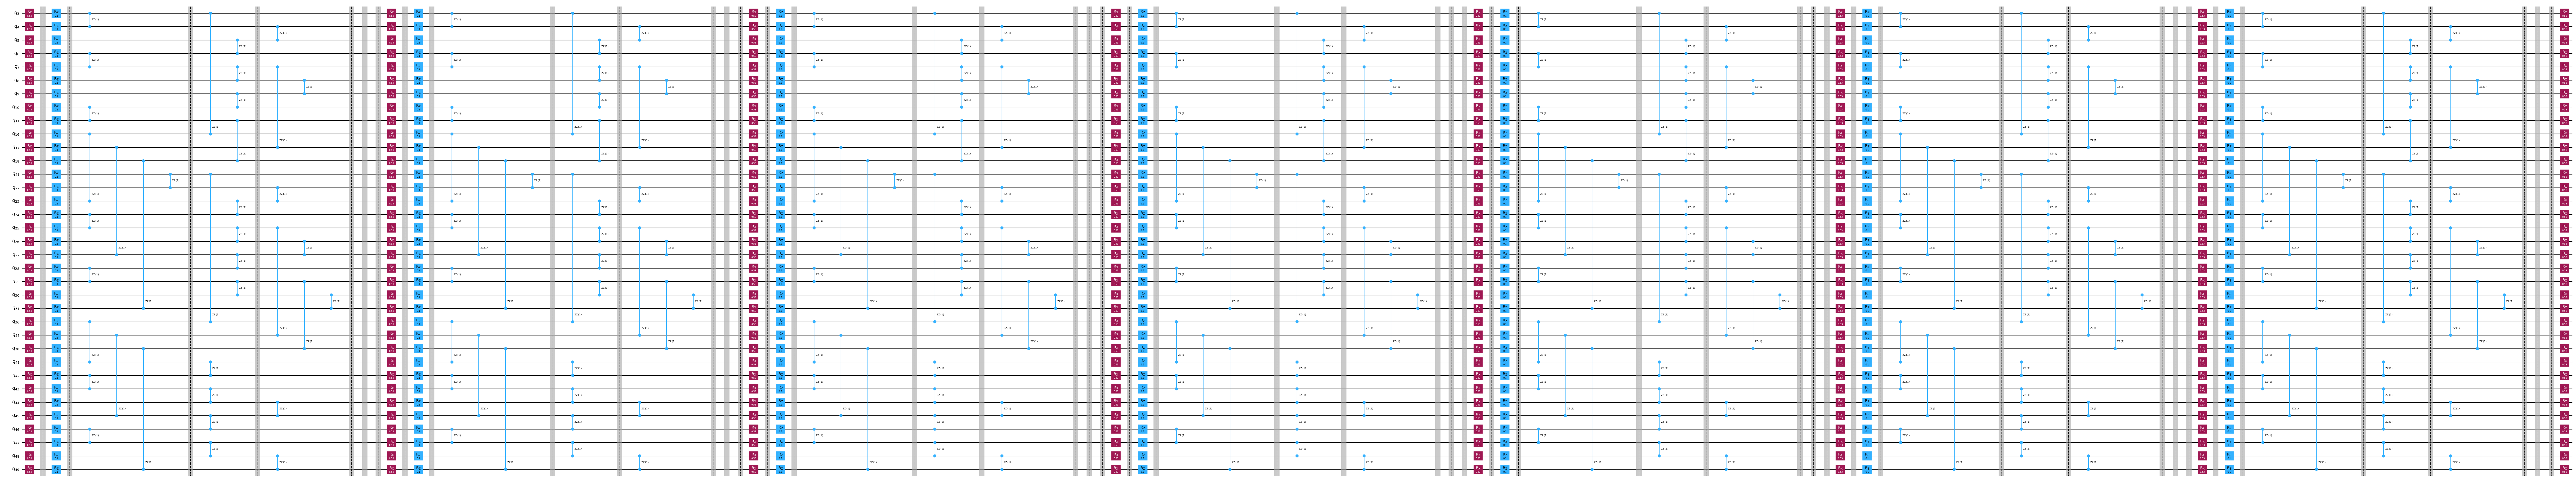

In [40]:
print("The remaining circuit after backpropagation looks as follows:")
bp_circ_vec[-1].draw("mpl", scale=0.8, fold=-1, idle_wires=False)
None

We can see that the backpropagation reduced 2 layers of the circuit.
Now that we have our reduced circuit and expanded observables, let's do time estimation to the backpropagated circuit:

In [42]:
# Start a job for empirical time estimation
estimation_job_obp = qesem_function.run(
    pubs=[(bp_circ_vec[-1], [bp_obs_vec[-1]])],
    instance=instance,
    backend_name=backend_name,
    options={
        "estimate_time_only": "empirical",
        "max_execution_time": 120,
        "default_precision": precision,
    },
)

In [48]:
print(estimation_job_obp.job_id)
print(estimation_job_obp.status())

8bae699d-a16b-4d39-bbd9-d123fbcce55d
DONE


In [49]:
result_obp = estimation_job_obp.result()

In [50]:
print(
    f"Empirical time estimation (sec): {result_obp[0].metadata['time_estimation_sec']}"
)

Empirical time estimation (sec): 900


We see that OBP reduces the time cost for mitigation of the circuit.

## Step 3: Execute using Qiskit primitives

### Run with real backend
Let's run the full experiment on a couple of trotter steps. The number of qubits, required precision and max QPU time can be modified according to the available QPU resources. Note that restricting the max QPU time will affect the final precision, you can see it in the final plot below.

We analyze four circuits with 5, 7, and 9 trotter steps at a precision of 0.05, comparing their ideal, noisy, and error-mitigated expectation values:

In [84]:
steps_vec = [5, 7, 9]

circ_vec = []
for steps in steps_vec:
    circ = trotter_circuit_from_layers(
        steps, theta_x, theta_z, theta_zz, layers
    )
    circ_vec.append(circ)

Again, performing OBP on each circuit to reduce runtime:

In [85]:
bp_circ_vec_35, bp_obs_vec_35 = run_backpropagation(circ_vec, observable, steps_vec)

n.o. steps: 5
Backpropagated 11 slices.
New observable has 363 terms, which can be combined into 4 groups.
After truncation, the error in our observable is bounded by 0.000e+00
-----------------
n.o. steps: 7
Backpropagated 11 slices.
New observable has 363 terms, which can be combined into 4 groups.
After truncation, the error in our observable is bounded by 0.000e+00
-----------------
n.o. steps: 9
Backpropagated 11 slices.
New observable has 363 terms, which can be combined into 4 groups.
After truncation, the error in our observable is bounded by 0.000e+00
-----------------


Now we run a batch of full QESEM jobs. We limit the maximal QPU runtime for each of the points for better control on the QPU budget.

In [106]:
run_on_real_hardware = True

precision = 0.05
if run_on_real_hardware:
    backend_name = "ibm_marrakesh"
else:
    backend_name = "fake_fez"

In [54]:
# Running full jobs for:
pubs_list = [
    [(bp_circ_vec_35[i], bp_obs_vec_35[i])]
    for i in range(len(bp_obs_vec_35))
]

In [55]:
# Initiating multiple jobs for different lengths
job_list = []
for pubs in pubs_list:
    job_obp = qesem_function.run(
        pubs=pubs,
        instance=instance,
        backend_name=backend_name,  # E.g. "ibm_brisbane"
        options={
            "max_execution_time": 300,  # Limits the QPU time, specified in seconds.
            "default_precision": 0.05,
        },
    )
    job_list.append(job_obp)

Checking the status of each job:

In [61]:
for job in job_list:
    print(job.status())

DONE
DONE
DONE
DONE


## Step 4: Post-process and return result in desired classical format

When all jobs are finished running, we can compare their noisy and mitigated expectation value

In [130]:
ideal_values = []
noisy_values = []
error_mitigated_values = []
error_mitigated_stds = []

for i in range(len(job_list)):
    job = job_list[i]
    result = job.result()  # Blocking - takes 3-5 minutes
    noisy_results = result[0].metadata["noisy_results"]

    ideal_val = calculate_ideal_evs(circ_vec[i], observable, n_qubits, i)
    print("---------------------------------")
    print(f"Ideal: {ideal_val}")
    print(f"Noisy: {noisy_results.evs}")
    print(f"QESEM: {result[0].data.evs} \u00b1 {result[0].data.stds}")

    ideal_values.append(ideal_val)
    noisy_values.append(noisy_results.evs)
    error_mitigated_values.append(result[0].data.evs)
    error_mitigated_stds.append(result[0].data.stds)

Using precalculated ideal values for large circuits calculated with belief propagation PEPS. Currently only for 35 qubits.
---------------------------------
Ideal: 0.79537
Noisy: 0.7039237951821501
QESEM: 0.7828018244130982 ± 0.013257266977728376
Using precalculated ideal values for large circuits calculated with belief propagation PEPS. Currently only for 35 qubits.
---------------------------------
Ideal: 0.78653
Noisy: 0.6478583812958806
QESEM: 0.7875259197423828 ± 0.02703045139248604
Using precalculated ideal values for large circuits calculated with belief propagation PEPS. Currently only for 35 qubits.
---------------------------------
Ideal: 0.79699
Noisy: 0.6171787879868142
QESEM: 0.6918791909168913 ± 0.0740873782039517


Lastly, we can plot the magnetization versus the number of steps. This summarizes the benefit of using QESEM Qiskit function for bias-free error mitigation on noisy quantum devices.

Text(0, 0.5, 'Magnetization')

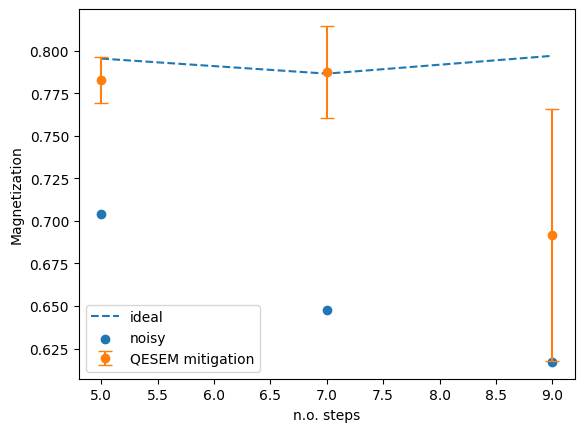

In [131]:
plt.plot(steps_vec, ideal_values, "--", label="ideal")
plt.scatter(steps_vec, noisy_values, label="noisy")
plt.errorbar(
    steps_vec,
    error_mitigated_values,
    yerr=error_mitigated_stds,
    fmt="o",
    capsize=5,
    label="QESEM mitigation",
)
plt.legend()
plt.xlabel("n.o. steps")
plt.ylabel("Magnetization")

<div class="alert alert-block alert-info">
<b>Note:</b>

The reason that the 9th step has a large statistical error bar is because we limited the QPU time to 5 minutes. If you run this step for 15 minutes (as the empirical time estimation suggests), you will get a smaller error bar. Hence, the mitigated value will become closer to the ideal value
